![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>LQR tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/LQR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an example of an LQR controller using [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme).

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

## All imports


In [1]:
# !pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


## Load and render the standard humanoid

In [2]:
print('Getting MuJoCo humanoid XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()


Getting MuJoCo humanoid XML description from GitHub:
Cloning into 'mujoco'...
remote: Enumerating objects: 25636, done.
remote: Counting objects: 100% (5459/5459), done.
remote: Compressing objects: 100% (1166/1166), done.
remote: Total 25636 (delta 4344), reused 4811 (delta 4154), pack-reused 20177 (from 1)
Receiving objects: 100% (25636/25636), 106.83 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (19769/19769), done.


The XML is used to instantiate an `MjModel`. Given the model, we can create an `MjData` which holds the simulation state, and an instance of the `Renderer` class defined above.

In [3]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

The state in the `data` object is in the default configuration. Let's invoke the forward dynamics to populate all the derived quantities (like the positions of geoms in the world), update the scene and render it:

""

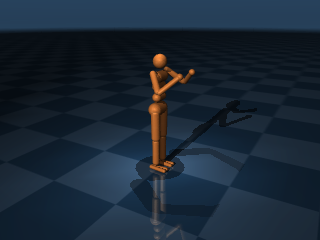

In [4]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

The model comes with some built-in "keyframes" which are saved simulation states.

`mj_resetDataKeyframe` can be used to load them. Let's see what they look like:

""

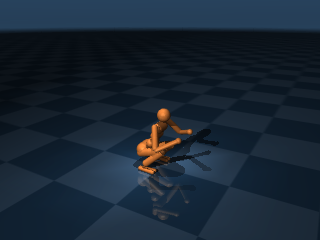

""

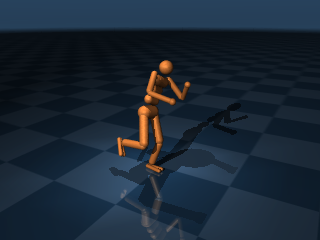

""

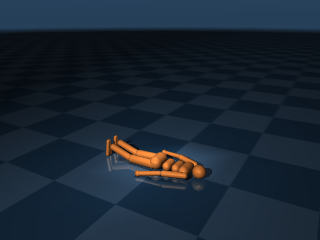

""

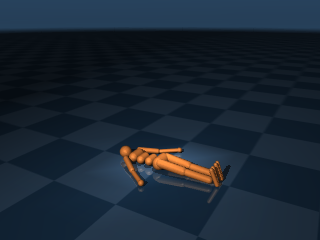

In [5]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

Now let's simulate the physics and render to make a video.

In [6]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

The model defines built-in torque actuators which we can use to drive the humanoid's joints by setting the `data.ctrl` vector. Let's see what happens if we inject noise into it.

While we're here, let's use a custom camera that will track the humanoid's center of mass.

In [7]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

## Stable standing on one leg

Clearly this initial pose is not stable. We'll try to find a stabilising control law using a [Linear Quadratic Regulator](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator).

### Recap of LQR theory
There are many online resources explaining this theory, developed by Rudolph Kalman in the 1960s, but we'll provide a minimal recap.

Given a dynamical system which is linear in the state $x$ and control $u$,
$$
x_{t+h} = A x_t + B u_t
$$
if the system fulfills a controllability criterion, it is possible to stabilize it (drive $x$ to 0) in an optimal fashion, as follows. Define a quadratic cost function over states and controls $J(x,u)$ using two Symmetric Positive Definite matrices $Q$ and $R$:
$$
J(x,u) = x^T Q x + u^T R u
$$

The cost-to-go $V^\pi(x_0)$, also known as the Value function, is the total sum of future costs, letting the state start at $x_0$ and evolve according to the dynamics, while using a control law $u=\pi(x)$:
$$
V^\pi(x_0) = \sum_{t=0}^\infty J(x_t, \pi(x_t))
$$
Kalman's central result can now be stated. The optimal control law which minimizes the cost-to-go (over all possible control laws!) is linear
$$
\pi^*(x) = \underset{\pi}{\text{argmin}}\; V^\pi(x)=-Kx
$$
and the optimal cost-to-go is quadratic
$$
V^*(x) =\underset{\pi}{\min}\; V^\pi(x) = x^T P x
$$
The matrix $P$ obeys the Riccati equation
$$
P = Q + A^T P A - A^T P B (R+B^T P B)^{-1} B^T P A
$$
and its relationship to the control gain matrix $K$ is
$$
K = (R + B^T  P B)^{-1} B^T P A
$$

### Understanding linearization setpoints

Of course our humanoid simulation is anything but linear. But while MuJoCo's `mj_step` function computes some non-linear dynamics $x_{t+h} = f(x_t,u_t)$, we can *linearize* this function around any state-control pair. Using shortcuts for the next state $y=x_{t+h}$, the current state $x=x_t$ and the current control $u=u_t$, and using $\delta$ to mean "small change in", we can write
$$
\delta y = \frac{\partial f}{\partial x}\delta x+ \frac{\partial f}{\partial u}\delta u
$$
In other words, the partial derivative matrices decribe a linear relationship between perturbations to $x$ and $u$ and changes to $y$. Comparing to the theory above, we can identify the partial derivative (Jacobian) matrices with the transition matrices $A$ and $B$, when considering the linearized dynamical system:
$$
A = \frac{\partial f}{\partial x} \quad
B = \frac{\partial f}{\partial u}
$$
In order to perform the linearization, we need to choose some setpoints $x$ and $u$ around which we will linearize. We already know $x$, this is our initial pose of standing on one leg. But what about $u$? How do we find the "best" control around which to linearise?

The answer is inverse dynamics.

### Finding the control setpoint using inverse dynamics

MuJoCo's forward dynamics function `mj_forward`, which we used above in order to propagate derived quantities, computes the acceleration given the state and all the forces in the system, some of which are created by the actuators.

The inverse dynamics function takes the acceleration as *input*, and computes the forces required to create the acceleration. Uniquely, MuJoCo's [fast inverse dynamics](https://doi.org/10.1109/ICRA.2014.6907751) takes into account all constraints, including contacts. Let's see how it works.

We'll call the forward dynamics at our desired position setpoint, set the acceleration in `data.qacc` to 0, and call the inverse dynamics:

In [8]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[  0.      0.    275.879 -33.186   4.995  -6.688  -4.305   3.693 -15.451 -10.906   0.412  -1.613
  -9.793  -2.312  -0.366  -5.913  -0.417  -1.914   5.759   2.665  -0.202  -5.755   0.994   1.141
  -1.987   3.821   1.151]


Examining the forces found by the inverse dynamics, we see something rather disturbing. There is a very large force applied at the 3rd degree-of-freedom (DoF), the vertical motion DoF of the root joint.

This means that in order to explain our assertion that the acceleration is zero, the inverse dynamics has to invent a "magic" force applied directly to the root joint. Let's see how this force varies as we move our humanoid up and down by just 1mm, in increments of 1$\mu$m:

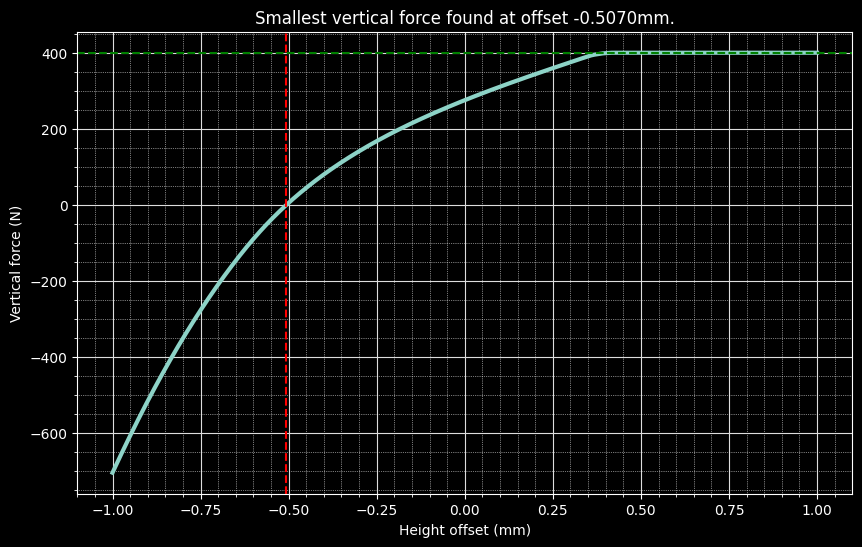

In [9]:
height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

In the plot above we can see the strong non-linear relationship due to foot contacts. On the left, as we push the humanoid into the floor, the only way to explain the fact that it is not jumping out of the floor is a large external force pushing it **down**. On the right, as we move the humanoid away from the floor the only way to explain the zero acceleration is a force holding it **up**, and we can clearly see the height at which the foot no longer touches the ground, and the required force is exactly equal to the humanoid's weight (green line), and remains constant as we keep moving up.

Near -0.5mm is the perfect height offset (red line), where the zero vertical acceleration can be entirely explained by internal joint forces, without resorting to "magical" external forces. Let's correct the height of our initial pose, save it in `qpos0`, and compute to inverse dynamics forces again:

In [10]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [  0.      0.     -0.191  -3.447   0.222  -0.817   2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


Much better, the forces on the root joint are small. Now that we have forces that can reasonably be produced by the actuators, how do we find the actuator values that will create them? For simple `motor` actuators like the humanoid's, we can simply "divide" by the actuation moment arm matrix, i.e. multiply by its pseudo-inverse:

In [11]:
actuator_moment = np.zeros((model.nu, model.nv))
mujoco.mju_sparse2dense(
    actuator_moment,
    data.actuator_moment,
    data.moment_rownnz,
    data.moment_rowadr,
    data.moment_colind,
)
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

TypeError: mju_sparse2dense(): incompatible function arguments. The following argument types are supported:
    1. (res: numpy.ndarray[numpy.float64[m, n], flags.writeable, flags.c_contiguous], mat: numpy.ndarray[numpy.float64[m, 1]], rownnz: numpy.ndarray[numpy.int32[m, 1]], rowadr: numpy.ndarray[numpy.int32[m, 1]], colind: numpy.ndarray[numpy.int32[m, 1]]) -> None

Invoked with: array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]]), array([[  0.,   0.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 120.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  80.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         40.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  40.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  80.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

More elaborate actuators would require a different method to recover $\frac{\partial \texttt{ qfrc_actuator}}{\partial \texttt{ ctrl}}$, and finite-differencing is always an easy option.

Let's apply these controls in the forward dynamics and compare the forces they produce with the desired forces printed above:

In [ ]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

Because the humanoid is fully-actuated (apart from the root joint), and the required forces are all within the actuator limits, we can see a perfect match with the desired forces across all internal joints. There is still some mismatch in the root joint, but it's small. Let's see what the simulation looks like when we apply these controls:

In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

Comparing to the completely passive video we made above, we can see that this is a much better control setpoint. The humanoid still falls down, but it tries to stabilize and succeeds for a short while.

### Choosing the $Q$ and $R$ matrices

In order to obtain the LQR feedback control law, we will need to design the $Q$ and $R$ matrices. Due to the linear structure, the solution is invariant to a scaling of both matrices, so without loss of generality we can choose $R$ to be the identity matrix:

In [ ]:
nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)

Choosing $Q$ is more elaborate. We will construct it as a sum of two terms.

First, a balancing cost that will keep the center of mass (CoM) over the foot. In order to describe it, we will use kinematic Jacobians which map between joint space and global Cartesian positions. MuJoCo computes these analytically.

In [ ]:
nv = model.nv  # Shortcut for the number of DoFs.

# Get the Jacobian for the root body (torso) CoM.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
mujoco.mj_forward(model, data)
jac_com = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('torso').id)

# Get the Jacobian for the left foot.
jac_foot = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('foot_left').id)

jac_diff = jac_com - jac_foot
Qbalance = jac_diff.T @ jac_diff

Second, a cost for joints moving away from their initial configuration. We will want different coefficients for different sets of joints:
- The free joint will get a coefficient of 0, as that is already taken care of by the CoM cost term.
- The joints required for balancing on the left leg, i.e. the left leg joints and the horizontal abdominal joints, should stay quite close to their initial values.
- All the other joints should have a smaller coefficient, so that the humanoid will, for example, be able to flail its arms in order to balance.

Let's get the indices of all these joint sets.



In [ ]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
root_dofs = range(6)
body_dofs = range(6, nv)
abdomen_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'abdomen' in name
    and not 'z' in name
]
left_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'left' in name
    and ('hip' in name or 'knee' in name or 'ankle' in name)
    and not 'z' in name
]
balance_dofs = abdomen_dofs + left_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

We are now ready to construct the Q matrix. Note that the coefficient of the balancing term is quite high. This is due to 3 separate reasons:
- It's the thing we care about most. Balancing means keeping the CoM over the foot.
- We have less control authority over the CoM (relative to body joints).
- In the balancing context, units of length are "bigger". If the knee bends by 0.1 radians (≈6°), we can probably still recover. If the CoM position is 10cm sideways from the foot position, we are likely on our way to the floor.

In [ ]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(nv)
Qjoint[root_dofs, root_dofs] *= 0  # Don't penalize free joint directly.
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

### Computing the LQR gain matrix $K$

Before we solve for the LQR controller, we need the $A$ and $B$ matrices. These are computed by MuJoCo's `mjd_transitionFD` function which computes them using efficient finite-difference derivatives, exploiting the configurable computation pipeline to avoid recomputing quantities which haven't changed.

In [ ]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

We are now ready to solve for our stabilizing controller. We will use `scipy`'s `solve_discrete_are` to solve the Riccati equation and get the feedback gain matrix using the formula described in the recap.

In [ ]:
# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

### Stable standing

We can now try our stabilising controller.

Note that in order to apply our gain matrix $K$, we need to use `mj_differentiatePos` which computes the difference of two positions. This is important because the root orientation is given by a length-4 quaternion, while the difference of two quaternions (in the tangent space) is length-3. In MuJoCo notation, positions (`qpos`) are of size `nq` while a position differences (and velocities) are of size `nv`.


In [ ]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### Final video

The video above is a bit disappointing, as the humanoid is basically motionless. Let's fix that and also add a few flourishes for our finale:
- Inject smoothed noise on top of the LQR controller so that the balancing action is more pronounced yet not jerky.
- Add contact force visualization to the scene.
- Smoothly orbit the camera around the humanoid.
- Instantiate a new renderer with higher resolution.

In [ ]:
# Parameters.
DURATION = 12         # seconds
FRAMERATE = 60        # Hz
TOTAL_ROTATION = 15   # degrees
CTRL_RATE = 0.8       # seconds
BALANCE_STD = 0.01    # actuator units
OTHER_STD = 0.08      # actuator units

# Make new camera, set distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# Set the scale of visualized contact forces to 1cm/N.
model.vis.map.force = 0.01

# Define smooth orbiting function.
def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time*2*np.pi)
def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time/DURATION) * TOTAL_ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION/model.opt.timestep))
perturb = np.random.randn(nsteps, nu)

# Scaling vector with different STD for "balance" and "other"
CTRL_STD = np.empty(nu)
for i in range(nu):
  joint = model.actuator(i).trnid[0]
  dof = model.joint(joint).dofadr[0]
  CTRL_STD[i] = BALANCE_STD if dof in balance_dofs else OTHER_STD

# Smooth the noise.
width = int(nsteps * CTRL_RATE/DURATION)
kernel = np.exp(-0.5*np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(model, width=1280, height=720)

frames = []
step = 0
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Add perturbation, increment step.
  data.ctrl += CTRL_STD * perturb[step]
  step += 1

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera, scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)